<a href="https://colab.research.google.com/github/AsadillahRamadhan/PCVK/blob/main/Kuis2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random
import os


import torch
import torch.nn as nn
import torchvision
from torchvision import datasets
from torch.utils.data import DataLoader
import torchvision.transforms as T
from torch.cuda.amp import GradScaler
from sklearn.metrics import accuracy_score

device = "cuda" if torch.cuda.is_available() else "cpu"

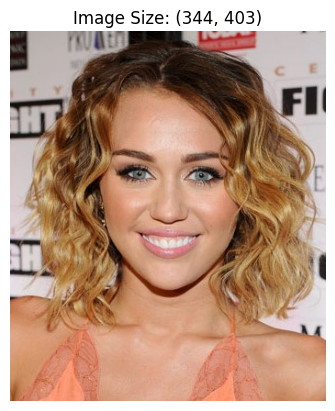

In [ ]:
example_image_path = random.choice(os.listdir('/content/drive/MyDrive/FaceShape Dataset/training_set/Heart'))
example_image_path = os.path.join("/content/drive/MyDrive/FaceShape Dataset/training_set/Heart", example_image_path)
example_image = Image.open(example_image_path)

plt.imshow(example_image)
plt.title(f"Image Size: {example_image.size}")
plt.axis('off')
plt.show()

In [ ]:
train_transforms = T.Compose([
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(degrees=10),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transforms = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
BATCH_SIZE = 64
NUM_WORKERS = os.cpu_count() - 1
TRAIN_PATH = "/content/drive/MyDrive/FaceShape Dataset/training_set/"
TEST_PATH = "/content/drive/MyDrive/FaceShape Dataset/testing_set"

def safe_pil_loader(path):
    try:
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('RGB')
    except (OSError, SyntaxError):
        return Image.new('RGB', (224, 224))

train_dataset = datasets.ImageFolder(root=TRAIN_PATH, transform=train_transforms, loader=safe_pil_loader)
test_dataset = datasets.ImageFolder(root=TEST_PATH, transform=test_transforms, loader=safe_pil_loader)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

In [ ]:
train_dataset.class_to_idx

{'Heart': 0, 'Oblong': 1, 'Oval': 2, 'Round': 3, 'Square': 4}

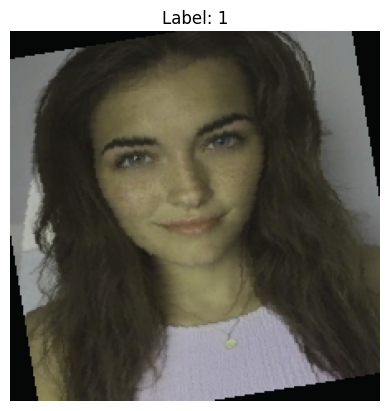

In [ ]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

example_image = images[0]
example_image = example_image.permute(1, 2, 0).numpy()
example_label = labels[0].item()

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
example_image = example_image * std + mean

plt.imshow(example_image)
plt.title(f"Label: {example_label}")
plt.axis('off')
plt.show()

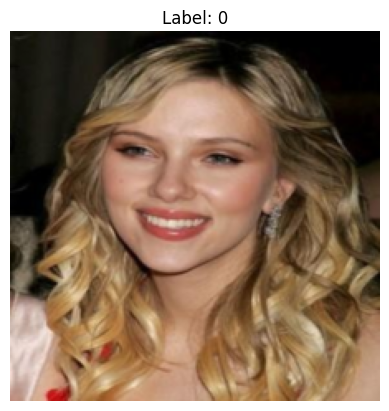

In [ ]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

example_image = images[0]
example_image = example_image.permute(1, 2, 0).numpy()
example_label = labels[0].item()

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
example_image = example_image * std + mean

plt.imshow(example_image)
plt.title(f"Label: {example_label}")
plt.axis('off')
plt.show()

In [ ]:
torch.manual_seed(42)

model = torchvision.models.alexnet(pretrained=True)

num_classes = len(train_dataset.classes)
model.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(model.classifier[1].in_features, num_classes)
    )

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-2, betas=(0.9, 0.999), weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

model.to(device)
num_epochs = 25
best_val_loss = 1_000_000

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:03<00:00, 64.4MB/s]


In [ ]:
scaler = GradScaler()

for epoch in range(num_epochs):
    model.train()
    train_losses =  []

    for inputs, labels in train_loader:

        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        with torch.autocast(device_type=device, dtype=torch.float16):
          outputs = model(inputs)
          loss = criterion(outputs, labels)

        scaler.scale(loss).backward()

        scaler.step(optimizer)
        scaler.update()

        train_losses.append(loss.item())

    avg_train_loss = sum(train_losses) / len(train_losses)

    model.eval()
    validation_losses = []
    all_predictions = []
    all_labels = []

    with torch.inference_mode():
      for inputs, labels in test_loader:

        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        validation_losses.append(loss)

        _, predicted = torch.max(outputs.data, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

      avg_val_loss = sum(validation_losses) / len(validation_losses)
      scheduler.step(avg_val_loss)

      accuracy = accuracy_score(all_labels, all_predictions)
      print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Accuracy: {accuracy:.4f}")

      if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        os.makedirs('models', exist_ok=True)
        torch.save(model.state_dict(), 'models/best_model.pth')
print(f'Best Validation Loss: {best_val_loss:.4f}')

Epoch 1/25, Train Loss: 122.5050, Validation Loss: 1.6118, Accuracy: 0.2004
Epoch 2/25, Train Loss: 1.6150, Validation Loss: 1.6098, Accuracy: 0.2000
Epoch 3/25, Train Loss: 1.6100, Validation Loss: 1.6095, Accuracy: 0.1998
Epoch 4/25, Train Loss: 1.6099, Validation Loss: 1.6095, Accuracy: 0.2002
Epoch 5/25, Train Loss: 1.6100, Validation Loss: 1.6097, Accuracy: 0.2002
Epoch 6/25, Train Loss: 1.6099, Validation Loss: 1.6095, Accuracy: 0.2000
Epoch 00007: reducing learning rate of group 0 to 1.0000e-03.
Epoch 7/25, Train Loss: 1.6101, Validation Loss: 1.6097, Accuracy: 0.2002
Epoch 8/25, Train Loss: 1.6095, Validation Loss: 1.6096, Accuracy: 0.2000
Epoch 9/25, Train Loss: 1.6096, Validation Loss: 1.6096, Accuracy: 0.2000
Epoch 10/25, Train Loss: 1.6095, Validation Loss: 1.6095, Accuracy: 0.2000
Epoch 00011: reducing learning rate of group 0 to 1.0000e-04.
Epoch 11/25, Train Loss: 1.6095, Validation Loss: 1.6095, Accuracy: 0.2000
Epoch 12/25, Train Loss: 1.6094, Validation Loss: 1.6095, 

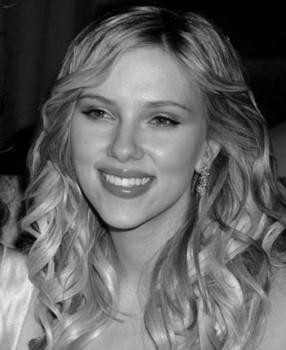

Predicted class: 1


In [ ]:
import torch
from torchvision.transforms import ToTensor
from google.colab.patches import cv2_imshow
import cv2 as cv

transform = ToTensor()
new_image = transform(Image.open('/content/drive/MyDrive/FaceShape Dataset/training_set/Heart/heart (1).jpg')).unsqueeze(0)  # Assuming you are using torchvision and PIL

# Make prediction
with torch.inference_mode():
    with torch.autocast(device_type='cuda', dtype=torch.float16):
        new_image = new_image.to('cuda')
        prediction = model(new_image)

# You may need to convert the prediction to a human-readable format based on your task
# For example, if it's a classification task, you may want to apply softmax
# and get the predicted class index
softmax = torch.nn.Softmax(dim=1)
probabilities = softmax(prediction)
predicted_class = torch.argmax(probabilities, dim=1).item()
image = cv.imread('/content/drive/MyDrive/FaceShape Dataset/training_set/Heart/heart (1).jpg', cv.IMREAD_GRAYSCALE)
cv2_imshow(image)
print(f"Predicted class: {predicted_class}")